### Info electrodes, rois, labels, AUC SCORE
#### From the beginning - electrodes included in the analysis
    Create the big file data 'all_subjects_info_elecs.csv'

In [2]:
from brainpipe.system import study
from os.path import isfile, join
import numpy as np
from itertools import product
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

conds = ['partial','detailed']
###############################################################################
st = study('Olfacto')
path_npz = join(st.path, 'figures_npz/1_'+conds[0]+'_'+conds[1]+'_4500_expi_noart/')
f_form = '{}_sources_phase_{}_odor_'+conds[0]+'_'+conds[1]+'_Expi_sel_phys.npz'
f_form = join(path_npz, f_form)
###############################################################################

freqs = ['0_VLFC', '1_delta', '2_theta', '3_alpha']

mat = np.load(f_form.format('All_subjects','0_VLFC'))
subjects, s_labels = mat['su_codes'][:,np.newaxis], mat['s_labels'][:,np.newaxis]
s_elec, s_channels = mat['s_elec'][:,np.newaxis], mat['s_channels'][:,np.newaxis]
s_aal, s_BA = mat['s_aal'][:,np.newaxis], mat['s_BA'][:,np.newaxis]
aal_RL = np.array([s_aal[i][0][:-4][:] for i in range(s_aal.shape[0])])[:,np.newaxis]
elec_data = np.concatenate((subjects, s_elec, s_channels, s_labels,s_aal,aal_RL,s_BA), axis=1)
df0 = pd.DataFrame(elec_data, columns=['subjects','elecs','channels','labels','aal','aal_RL','BA'])
#cols = pd.MultiIndex.from_product([['subjects','elecs','channels','labels','aal','aal_RL'],['_']])
#df = pd.DataFrame(elec_data, columns=cols)
dfname = '0_all_subjects_info_elecs.csv'
df0.to_csv(path_npz+dfname)

# load all electrodes information and create a df
da_data = np.array([])
for freq in freqs:
    mat = np.load(f_form.format('All_subjects',freq))
    da = np.asarray([max(mat['s_da'][i,:]) for i in range(mat['s_da'].shape[0])])[np.newaxis]
    da_data = np.vstack((da_data,da)) if np.size(da_data) else da
df2 = pd.DataFrame(da_data.T, columns=['0_VLFC','1_delta', '2_theta', '3_alpha'])
df_all = pd.concat((df0,df2),axis=1)
#df_all = df.join(df2, how='left')
df_all_name = '1_all_subjects_info_elecs_AUC_Max.csv'
df_all.to_csv(path_npz+df_all_name)

-> Olfacto loaded


#### Plot nb electrodes by subjects - TOTAL

<IPython.core.display.Javascript object>


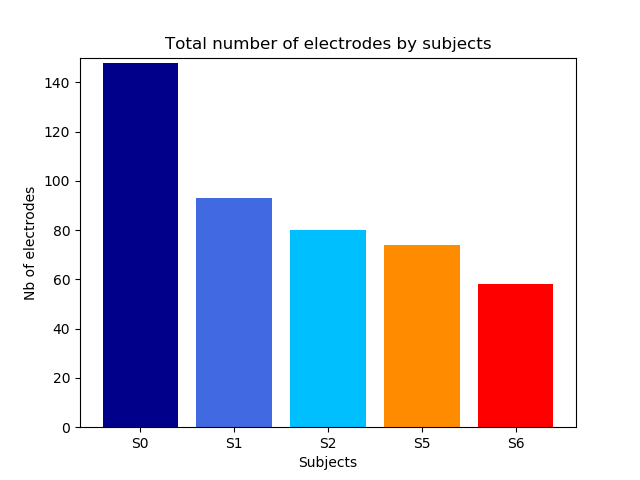

In [3]:
### PLOTS BY ROIs AND SUBJECTS
colors = {'S0':'darkblue', 'S1':'royalblue', 'S2':'deepskyblue', 'S3':'mediumspringgreen',
          'S4':'yellow', 'S5':'darkorange', 'S6':'red'}

## total nb of electrodes by patient
elecs_su = df0[['subjects','elecs']].groupby(['subjects']).count()
# print(elecs_su,'sel',elecs_su['elecs'])
fig = plt.figure()
plt.bar(range(len(elecs_su)), elecs_su['elecs'],
        color=[colors[i] for i,row in elecs_su.iterrows()])
plt.title('Total number of electrodes by subjects')
plt.ylabel('Nb of electrodes')
plt.xlabel('Subjects')
xticks_pos = np.arange(len(elecs_su))
plt.xticks(xticks_pos,list(elecs_su['elecs'].index.values))
plt.ylim(bottom=0, top=150)
plt.savefig(path_npz+'Total_elec_by_patient.png')

#### Plot nb electrodes by ROIs by subects - TOTAL

<IPython.core.display.Javascript object>


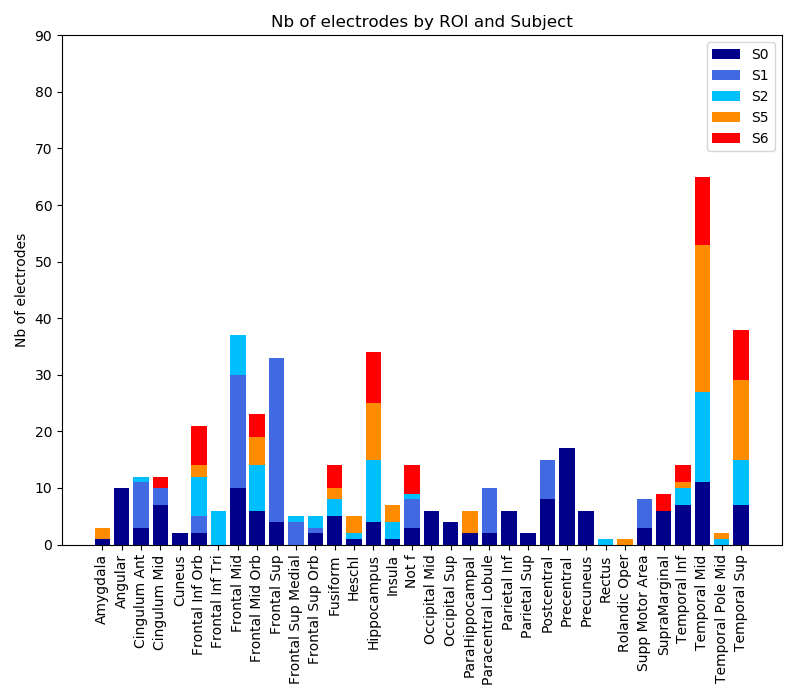

In [4]:
%matplotlib notebook
method='aal_RL'
# Create a column with R and L aal labels merged
elecs_su_roi = df0.groupby(['subjects',method]).count()['elecs'].unstack()
elecs_su_roi = elecs_su_roi.fillna(0)

#Plot nb of electrodes for each subjects
colors = {'S0':'darkblue', 'S1':'royalblue', 'S2':'deepskyblue', 'S3':'mediumspringgreen',
           'S4':'yellow', 'S5':'darkorange', 'S6':'red'}
fig = plt.figure(figsize=(8,7))
bottom = np.zeros(len(elecs_su_roi.columns))
for s in enumerate(elecs_su_roi.index):
    count = elecs_su_roi.iloc[elecs_su_roi.index.get_level_values('subjects') == s[1]].values[0]
    xpts = range(len(count))
    plt.bar(xpts, count, bottom=bottom, color=colors[s[1]], label=s[1])
    bottom += count

plt.title('Nb of electrodes by ROI and Subject')
plt.ylabel('Nb of electrodes')
plt.xticks(xpts,list(elecs_su_roi.columns.values),rotation=90)
plt.tight_layout()
plt.ylim(bottom=0, top=90)
plt.legend(loc='best')
plt.savefig(path_npz+'Total_elec_by_patient_by_roi_'+method+'.png')
#plt.clf()
#plt.close()

#### Plot nb of signif electrodes by subjects and freq - TOTAL

-> Olfacto loaded


<IPython.core.display.Javascript object>


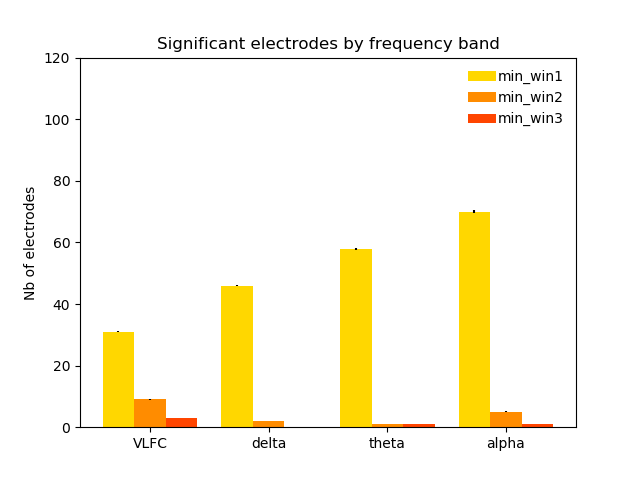

<IPython.core.display.Javascript object>


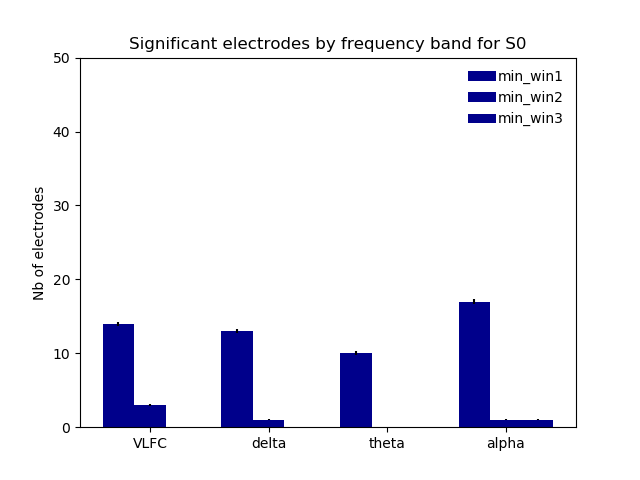

<IPython.core.display.Javascript object>


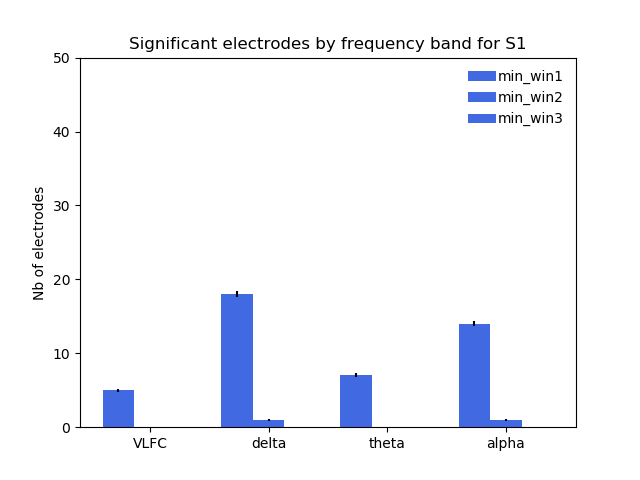

<IPython.core.display.Javascript object>


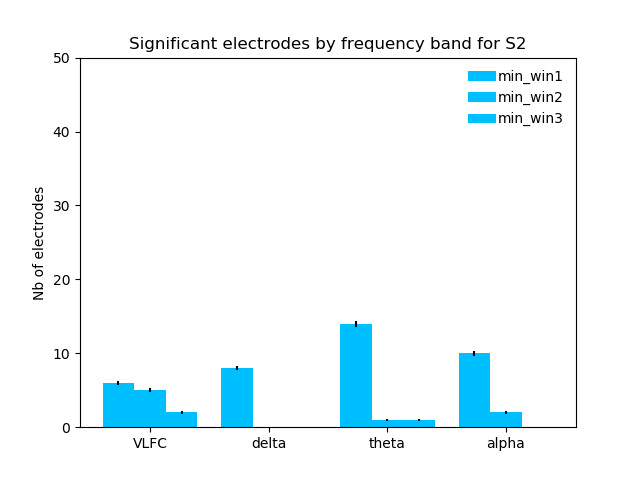

<IPython.core.display.Javascript object>


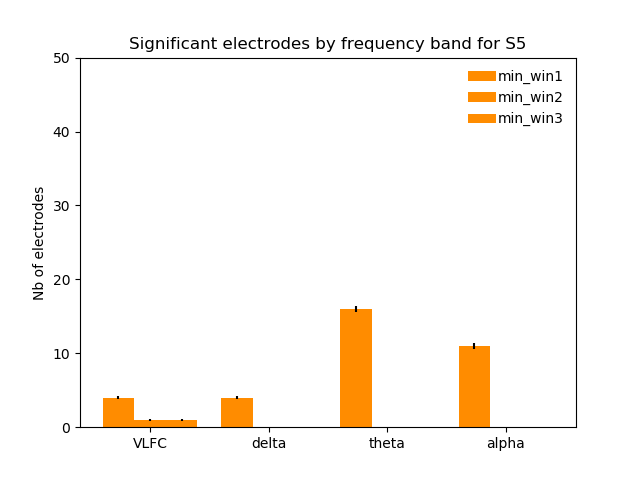

<IPython.core.display.Javascript object>


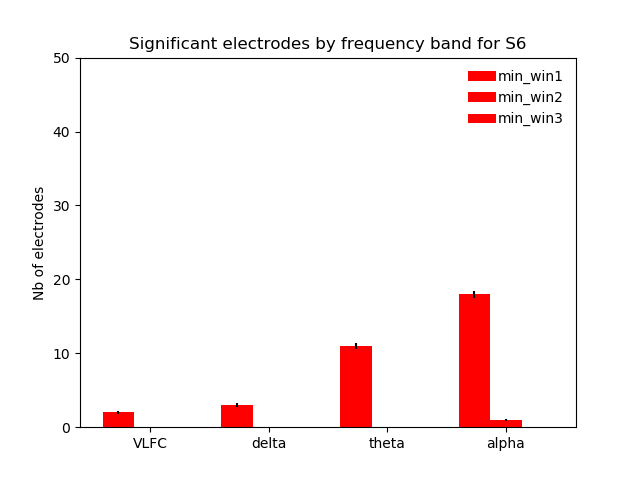

In [5]:
from brainpipe.system import study
from os import makedirs
from os.path import isfile, join, exists
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
%matplotlib notebook
from itertools import product

conds,ths, bsl = ['partial', 'detailed'],['05'], 'None'
min_wins = ['1','2','3']
###############################################################################
st = study('Olfacto')
path = join(st.path+'/figures_npz/1_'+conds[0]+'_'+conds[1]+'_4500_expi_noart/')
path_mask = path+'masks_stat/'
path2save = path+'Signif_elecs/'
freqs = ['0_VLFC','1_delta', '2_theta', '3_alpha']
freqnames = [freq[2:] for freq in freqs]
minwin_names = ['min_win'+str(min_win[:]) for min_win in min_wins]
f_form = 'All_subjects_mask_stat_{}_minwin{}_th{}.npy'
f_form = join(path_mask, f_form)
###############################################################################
if not exists(path2save):
    makedirs(path2save)
###############################################################################

all_mask=np.array([])
for th, freq in product(ths,freqs):
    for min_win in min_wins:
        mask = np.load(f_form.format(freq,min_win,th))[:,np.newaxis]
        all_mask = np.concatenate((all_mask,mask), axis=1) if all_mask.size else mask
#create a DataFrame with all stats for all freqs
cols = pd.MultiIndex.from_product([freqnames,minwin_names])
df = pd.DataFrame(all_mask, columns=cols) #boolean df
# Tranform True value by 0 and False value by 1
df = df*-1+1

# Load elecs file information
filename = '0_all_subjects_info_elecs.csv'
df2 = pd.read_csv(path+filename, sep=',')
df2 = pd.concat([df2,df], axis=1)
df2.drop(['Unnamed: 0'],inplace=True, axis=1)
df2.set_index(['subjects'], inplace=True)
df_name = '2_all_subjects_info_elecs_AUC_Signif_th_'+th+'_'+bsl+'.csv'
df2.to_csv(path+df_name)

#Plot nb of significant electrodes by win
fig = plt.figure()
plt.title('Significant electrodes by frequency band')
plt.ylabel('Nb of electrodes')
xticks, w = np.arange(0,len(freqnames)*3,3), 0.8
plt.xticks(xticks+w,freqnames)
plt.ylim(bottom=0, top=120)

colors_w = ['gold','darkorange','orangered']
for i, win in enumerate(minwin_names):
    df3 = df2.filter(like=(win)).agg(('sum','std','sem'))
    plt.bar(xticks+(w*i),df3.loc[['sum']].values[0],color=colors_w[i],
            yerr=df3.loc[['std']].values[0], label=minwin_names[i])
plt.show()
plt.legend(loc=0,handletextpad=0.1, frameon=False)
plt.savefig(path2save+'Total_elec_signif_freq_4500_th_'+th+'.png')

#Plot nb of significant electrodes by win and subjects
colors = {'S0':'darkblue', 'S1':'royalblue', 'S2':'deepskyblue', 
        'S3':'mediumspringgreen','S4':'yellow', 'S5':'darkorange', 'S6':'red'}
df4 = df2.groupby(['subjects']).agg(('sum','std'))
xticks, w = np.arange(0,len(freqnames)*3,3), 0.8
for i,su in enumerate(df4.index):
    fig = plt.figure()
    for j,min_win in enumerate(min_wins):
        count = df4.iloc[[i]].filter(like='sum').filter(like=minwin_names[j]).values[0]
        err = df4.iloc[[i]].filter(like='std').filter(like=minwin_names[j]).values[0]
        plt.bar(xticks+w*j, count, color=colors[su], label=minwin_names[j], yerr=err)
    plt.title('Significant electrodes by frequency band for '+su)
    plt.ylabel('Nb of electrodes')
    plt.xticks(xticks+w,freqnames)
    plt.ylim(bottom=0, top=(50))
    plt.legend(loc=0,handletextpad=0.1, frameon=False)
    plt.show()
    plt.savefig(path2save+su+'_elec_signif_freq_4500_th_'+th+'.png')


#### Plot signif electrodes by frequency bands, subjects and ROIs

-> Olfacto loaded
freq VLFC min_win 1 data signif (5, 4)
['Cingulum Ant' 'Frontal Mid' 'Insula' 'Temporal Mid']
freq VLFC min_win 1 data signif (5, 1)
['Frontal Mid']
freq VLFC min_win 1 data signif (5, 0)
freq VLFC min_win 1 data signif (5, 0)
freq VLFC min_win 2 data signif (5, 2)
['Cingulum Ant' 'Insula']
freq VLFC min_win 2 data signif (5, 0)
freq VLFC min_win 2 data signif (5, 0)
freq VLFC min_win 2 data signif (5, 0)
freq VLFC min_win 3 data signif (5, 0)
freq VLFC min_win 3 data signif (5, 0)
freq VLFC min_win 3 data signif (5, 0)
freq VLFC min_win 3 data signif (5, 0)
freq delta min_win 1 data signif (5, 5)
['Cingulum Ant' 'Frontal Mid' 'Frontal Mid Orb' 'Supp Motor Area'
 'Temporal Sup']
freq delta min_win 1 data signif (5, 2)
['Frontal Mid' 'Temporal Sup']
freq delta min_win 1 data signif (5, 0)
freq delta min_win 1 data signif (5, 0)
freq delta min_win 2 data signif (5, 0)
freq delta min_win 2 data signif (5, 0)
freq delta min_win 2 data signif (5, 0)
freq delta min_win 2 da

<IPython.core.display.Javascript object>


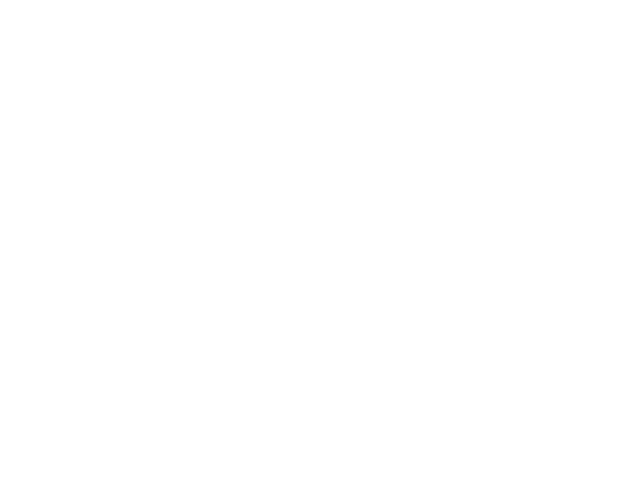

freq theta min_win 1 data signif (5, 2)
['Frontal Mid Orb' 'Temporal Sup']


<IPython.core.display.Javascript object>


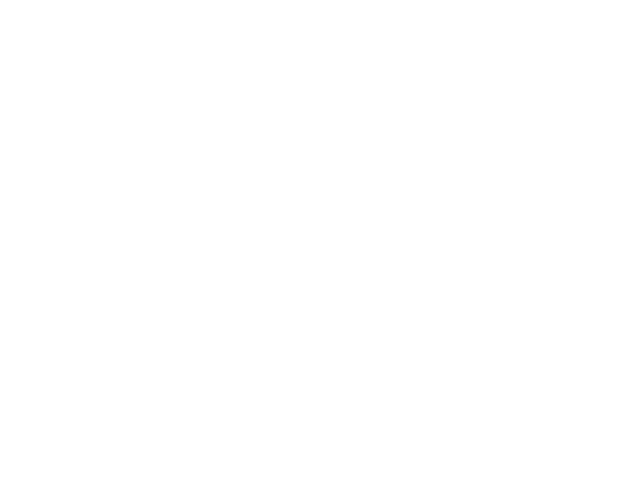

freq theta min_win 1 data signif (5, 0)
freq theta min_win 2 data signif (5, 0)
freq theta min_win 2 data signif (5, 0)
freq theta min_win 2 data signif (5, 0)
freq theta min_win 2 data signif (5, 0)
freq theta min_win 3 data signif (5, 0)
freq theta min_win 3 data signif (5, 0)
freq theta min_win 3 data signif (5, 0)
freq theta min_win 3 data signif (5, 0)
freq alpha min_win 1 data signif (5, 9)
['Cingulum Mid' 'Frontal Inf Orb' 'Frontal Mid' 'Frontal Mid Orb'
 'Frontal Sup' 'Hippocampus' 'Postcentral' 'Temporal Mid' 'Temporal Sup']


<IPython.core.display.Javascript object>


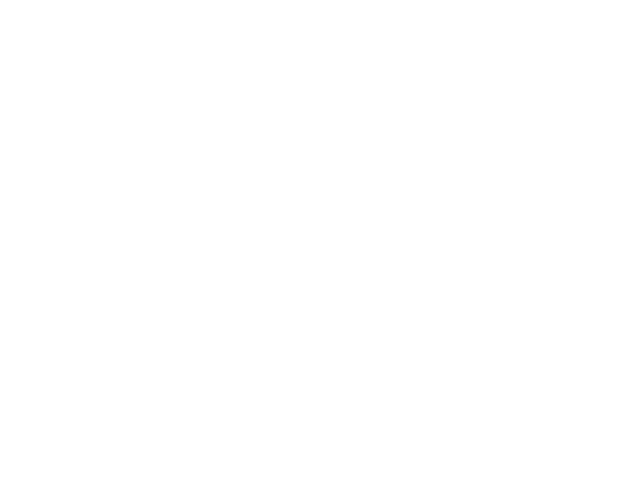

freq alpha min_win 1 data signif (5, 6)
['Frontal Inf Orb' 'Frontal Mid' 'Frontal Mid Orb' 'Hippocampus'
 'Temporal Mid' 'Temporal Sup']


<IPython.core.display.Javascript object>


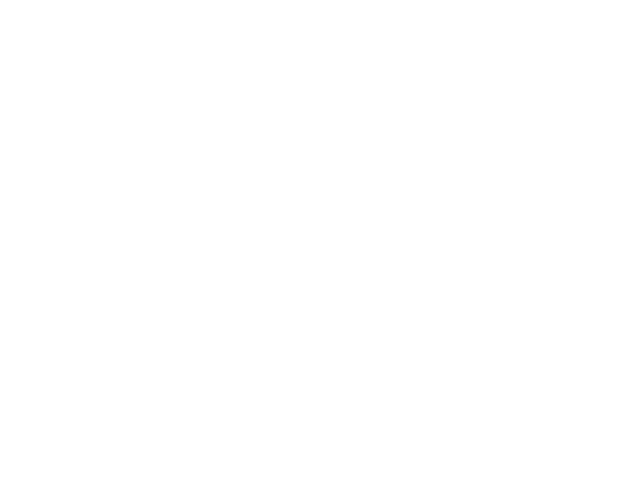

freq alpha min_win 1 data signif (5, 1)
['Frontal Mid Orb']


<IPython.core.display.Javascript object>


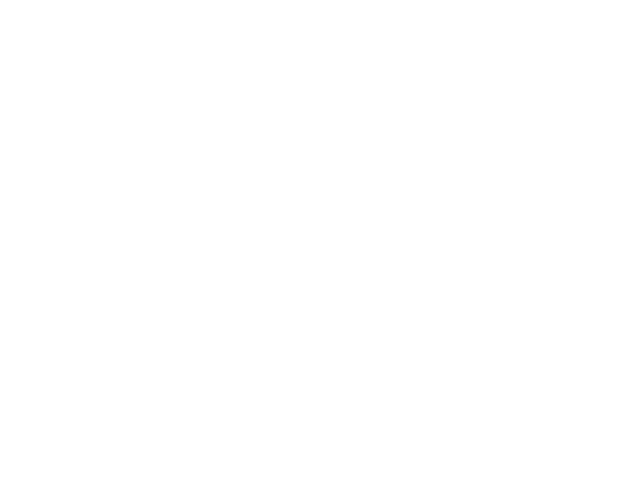

freq alpha min_win 1 data signif (5, 0)
freq alpha min_win 2 data signif (5, 0)
freq alpha min_win 2 data signif (5, 0)
freq alpha min_win 2 data signif (5, 0)
freq alpha min_win 2 data signif (5, 0)
freq alpha min_win 3 data signif (5, 0)
freq alpha min_win 3 data signif (5, 0)
freq alpha min_win 3 data signif (5, 0)
freq alpha min_win 3 data signif (5, 0)
freq VLFC min_win 1 data signif (5, 6)
['BA20' 'BA21' 'BA32' 'BA37' 'BA4' 'BA48']


<IPython.core.display.Javascript object>


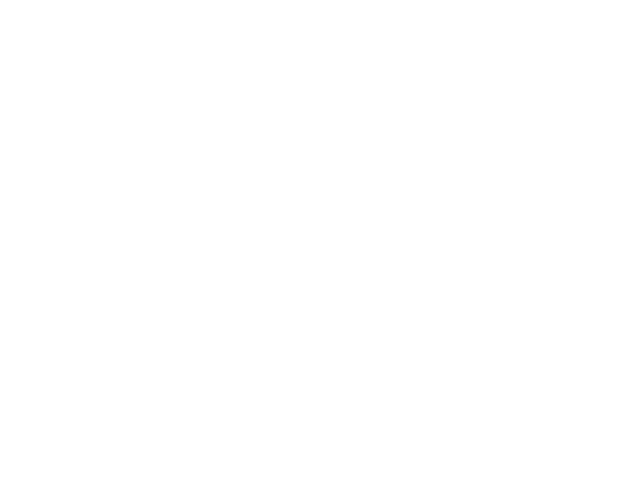

freq VLFC min_win 1 data signif (5, 3)
['BA20' 'BA21' 'BA32']


<IPython.core.display.Javascript object>


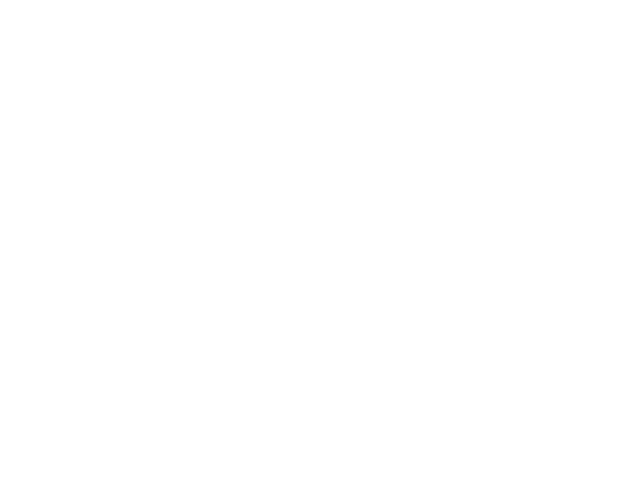

freq VLFC min_win 1 data signif (5, 0)
freq VLFC min_win 1 data signif (5, 0)
freq VLFC min_win 2 data signif (5, 2)
['BA32' 'BA48']


<IPython.core.display.Javascript object>


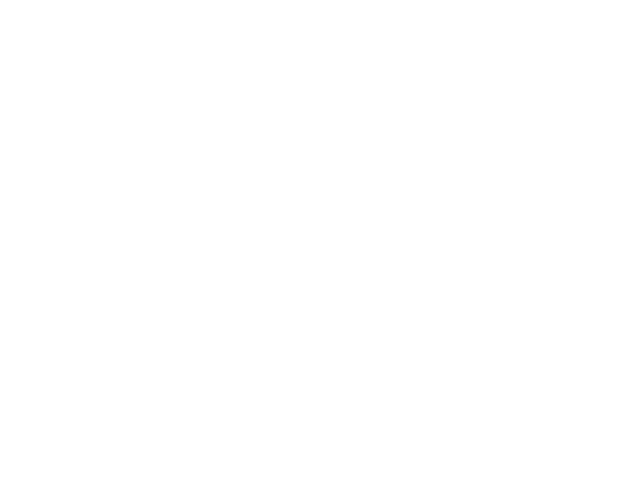

freq VLFC min_win 2 data signif (5, 0)
freq VLFC min_win 2 data signif (5, 0)
freq VLFC min_win 2 data signif (5, 0)
freq VLFC min_win 3 data signif (5, 0)
freq VLFC min_win 3 data signif (5, 0)
freq VLFC min_win 3 data signif (5, 0)
freq VLFC min_win 3 data signif (5, 0)
freq delta min_win 1 data signif (5, 7)
['BA11' 'BA20' 'BA22' 'BA32' 'BA46' 'BA48' 'BA6']


<IPython.core.display.Javascript object>


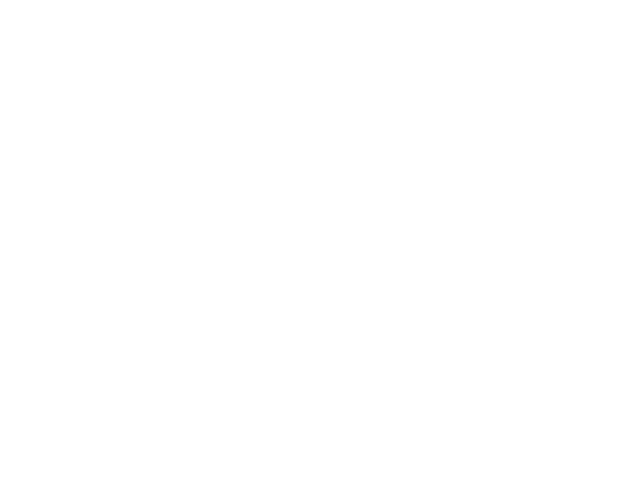

freq delta min_win 1 data signif (5, 1)
['BA48']


<IPython.core.display.Javascript object>


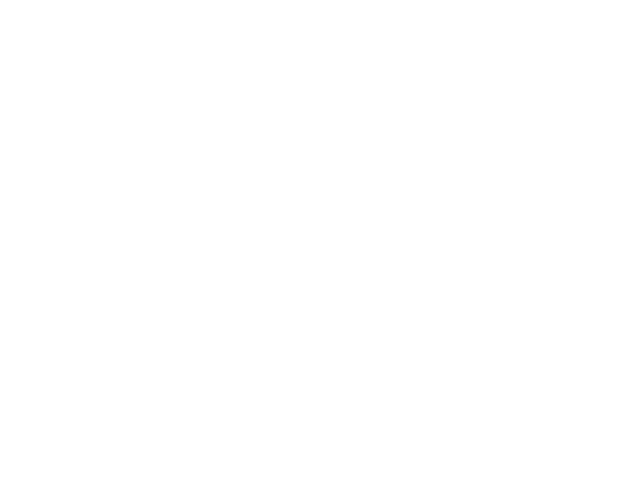

freq delta min_win 1 data signif (5, 0)
freq delta min_win 1 data signif (5, 0)
freq delta min_win 2 data signif (5, 0)
freq delta min_win 2 data signif (5, 0)
freq delta min_win 2 data signif (5, 0)
freq delta min_win 2 data signif (5, 0)
freq delta min_win 3 data signif (5, 0)
freq delta min_win 3 data signif (5, 0)
freq delta min_win 3 data signif (5, 0)
freq delta min_win 3 data signif (5, 0)
freq theta min_win 1 data signif (5, 8)
['BA11' 'BA20' 'BA21' 'BA22' 'BA40' 'BA47' 'BA48' 'BA9']


<IPython.core.display.Javascript object>


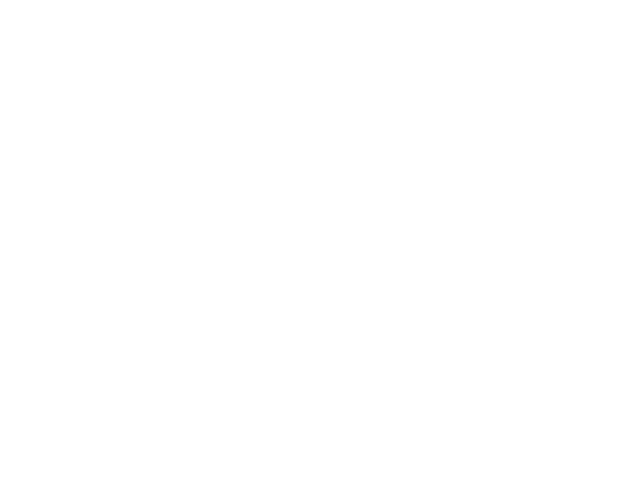

freq theta min_win 1 data signif (5, 4)
['BA11' 'BA20' 'BA47' 'BA48']


<IPython.core.display.Javascript object>


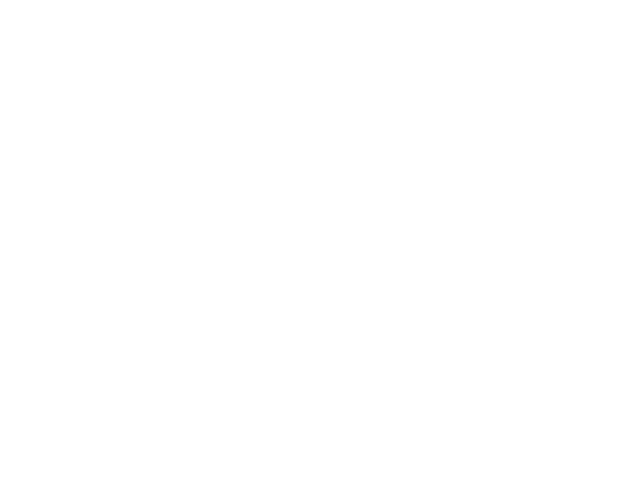

freq theta min_win 1 data signif (5, 2)
['BA11' 'BA48']


<IPython.core.display.Javascript object>


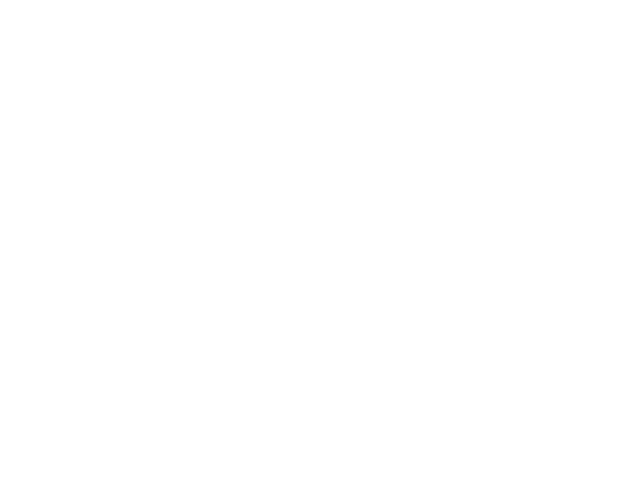

freq theta min_win 1 data signif (5, 0)
freq theta min_win 2 data signif (5, 0)
freq theta min_win 2 data signif (5, 0)
freq theta min_win 2 data signif (5, 0)
freq theta min_win 2 data signif (5, 0)
freq theta min_win 3 data signif (5, 0)
freq theta min_win 3 data signif (5, 0)
freq theta min_win 3 data signif (5, 0)
freq theta min_win 3 data signif (5, 0)
freq alpha min_win 1 data signif (5, 10)
['BA11' 'BA20' 'BA21' 'BA4' 'BA46' 'BA47' 'BA48' 'BA6' 'BA8' 'Not found']


<IPython.core.display.Javascript object>


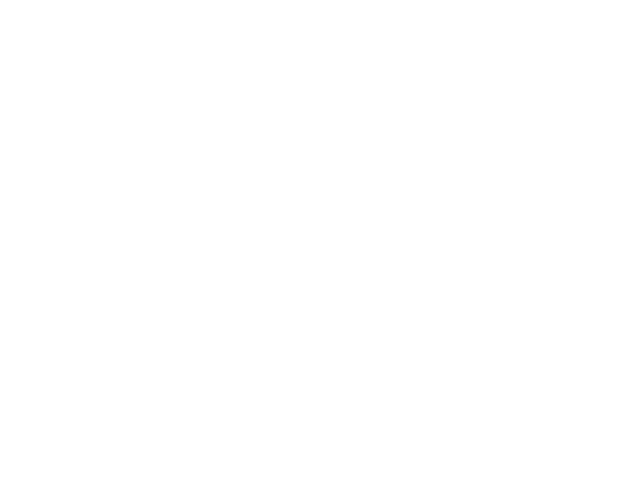

freq alpha min_win 1 data signif (5, 5)
['BA11' 'BA20' 'BA21' 'BA47' 'BA48']


<IPython.core.display.Javascript object>


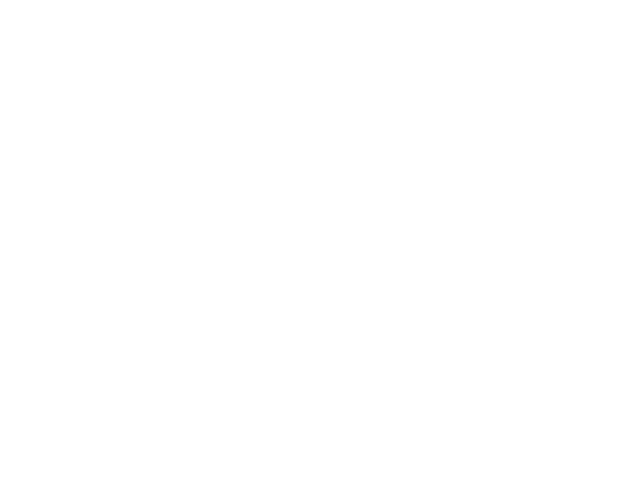

freq alpha min_win 1 data signif (5, 2)
['BA11' 'BA20']


<IPython.core.display.Javascript object>


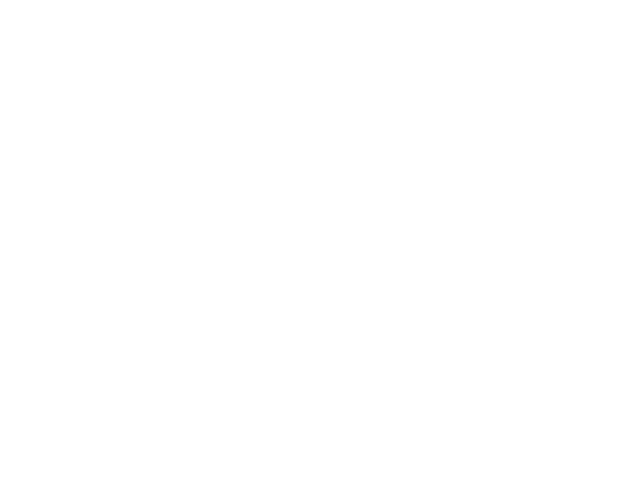

freq alpha min_win 1 data signif (5, 0)
freq alpha min_win 2 data signif (5, 0)
freq alpha min_win 2 data signif (5, 0)
freq alpha min_win 2 data signif (5, 0)
freq alpha min_win 2 data signif (5, 0)
freq alpha min_win 3 data signif (5, 0)
freq alpha min_win 3 data signif (5, 0)
freq alpha min_win 3 data signif (5, 0)
freq alpha min_win 3 data signif (5, 0)


In [6]:
from brainpipe.system import study
from itertools import product
from os import makedirs
from os.path import isfile, join, exists
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

conds,th, bsl = ['partial', 'detailed'],'05','None'
methods = ['aal_RL','BA']
min_wins, min_sigs = ['1','2','3'], [2,3,4,5]
###############################################################################
st = study('Olfacto')
path = join(st.path+'/figures_npz/1_'+conds[0]+'_'+conds[1]+'_4500_expi_noart/')
path2save = path+'/Signif_ROIs/'
freqs = ['0_VLFC','1_delta', '2_theta', '3_alpha']
freqnames = [freq[2:] for freq in freqs]
minwin_names = ['min_win'+str(min_win[:]) for min_win in min_wins]
###############################################################################
if not exists(path2save):
    makedirs(path2save)
###############################################################################

for method in methods:
    filename = '2_all_subjects_info_elecs_AUC_Signif_th_'+th+'_'+bsl+'.csv'
    df = pd.read_csv(path+filename, sep=',')
    df = df.drop(['elecs'], axis=1).set_index(['subjects', method])
    df2 = df.groupby(['subjects',method]).sum().unstack()
    df2 = df2.fillna(0)
    df2 = df2.swaplevel(0,1,axis =1)

    colors = {'S0':'darkblue', 'S1':'royalblue', 'S2':'deepskyblue', 
            'S3':'mediumspringgreen','S4':'yellow', 'S5':'darkorange', 'S6':'red'}

    for freq in freqnames:
        for min_win, min_sig in product(min_wins, min_sigs):
            df_sel = df2.filter(like='min_win'+min_win).filter(like=freq)
            df3=df_sel
            for i in range(len(df_sel.columns.levels[0])):
                df3 = df3
                col = df_sel.iloc[:,[i]]
                if df_sel.iloc[:,[i]].values.astype(bool).sum() < min_sig:
                    df3 = df3.drop(col,axis=1)
                else:
                    continue
            print('freq', freq, 'min_win',min_win, 'data signif',df3.shape)
            if df3.shape[1]>0:
                names = np.array(df3.columns.get_level_values(0).values)
                print(names)
                np.save((path2save+method+'_signif_min_'+str(min_sig)+'_'+freq+'_min_win'+min_win+'_th_'+th+'.npy'),names)
                bottom = np.zeros(len(df3.columns))
                for s in df3.index:
                    count = df3.iloc[df3.index == s].values[0]
                    xpts = range(len(count))
                    plt.bar(xpts, count, bottom=bottom, color=colors[s], label=s, width=0.8)
                    bottom += count
                plt.title('Significant electrodes by ROI/Subject for '+freq+' min_win'+min_win+' th '+th)
                plt.ylabel('Nb of electrodes')
                plt.xticks(xpts,list(df3.columns.get_level_values(0)),rotation=90)
                plt.tight_layout()
                plt.ylim(bottom=0, top=40)
                plt.xlim(xmin=-1,xmax=12)
                plt.legend(loc='best')
                plt.savefig(path2save+method+'_signif_min_'+str(min_sig)+'_'+freq+'_min_win'+min_win+'_th_'+th+'.png')
                plt.clf()
                plt.close()